In [0]:
import torch.nn as nn
import torch
import numpy as np
import torch.nn.functional as F

# Designing Inverted Residual Block


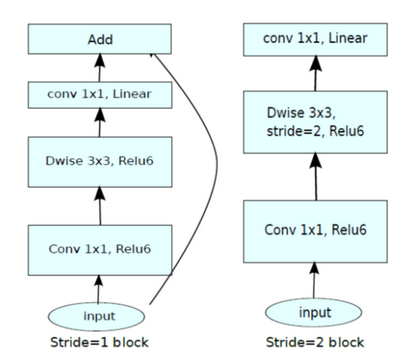

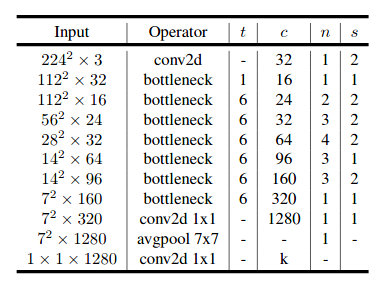

In [0]:
class Inverted_Residual(nn.Module):
    """
        inverted residual gets activated when stride = 1 and input_channels = output_channels
        otherwise no residual connection will be there
        Also if expand ratio is 1, there will be no expansion layer
        
        inp = input channels
        out = ouput channels
        stride_ = stride of depth wise conv layer


    """

    def __init__(self, inp, out, expand_ratio, stride_):
        super(Inverted_Residual, self).__init__()
        # getting the number of channels after expansion


        self.residual_connection = True if stride_ == 1 and inp == out else False
                 
        hidden_channels = inp*expand_ratio

        if expand_ratio == 1:

            self.layers = nn.Sequential(
                       nn.Conv2d(in_channels=hidden_channels,out_channels=hidden_channels,groups=hidden_channels,
                                        kernel_size=3, padding=1, stride=stride_),
                       nn.BatchNorm2d(hidden_channels),
                       nn.ReLU6(inplace=True),

                       nn.Conv2d(in_channels=hidden_channels, out_channels=out, kernel_size=1, padding=0, stride=1),
                       nn.BatchNorm2d(out)
                                   )

        else: 

            self.layers = nn.Sequential(
                       nn.Conv2d(in_channels=inp, out_channels=hidden_channels, kernel_size=1, padding=0, stride=1),
                       nn.BatchNorm2d(hidden_channels),
                       nn.ReLU6(inplace=True),

                       # if stride_ = 2 and padding = 1 do a maxpool similar operation eg: 112 x 112-> 56 x 56
                       nn.Conv2d(in_channels=hidden_channels,out_channels=hidden_channels,groups=hidden_channels,
                                        kernel_size=3, padding=1, stride=stride_),
                       nn.BatchNorm2d(hidden_channels),
                       nn.ReLU6(inplace=True),

                       nn.Conv2d(in_channels=hidden_channels, out_channels=out, kernel_size=1, padding=0, stride=1),
                       nn.BatchNorm2d(out)
                                  )

 
        
    def forward(self,x):
        x_out = self.layers(x)
        if self.residual_connection:
            x_out = x + self.layers(x)
        # print(x_out.shape)   
        return x_out


In [107]:
# testing
x = torch.rand(1,32,112,112)
print(x.shape)
model = Inverted_Residual(32,32,6,1)
out = model(x)
print(out.shape)

torch.Size([1, 32, 112, 112])
torch.Size([1, 32, 112, 112])


Now we will design our network

In [0]:
def conv3x3_bn(inp,out,stride_):
    x = nn.Sequential(
        nn.Conv2d(in_channels=inp,out_channels=out,kernel_size=3,padding=1,stride=stride_),
        nn.BatchNorm2d(out),
        nn.ReLU6(inplace=True)
    )

    return x

def conv1x1_bn(inp,out):
    x = nn.Sequential(
        nn.Conv2d(in_channels=inp,out_channels=out,kernel_size=1,padding=0,stride=1),
        nn.BatchNorm2d(out),
        nn.ReLU6(inplace=True)
    )

    return x



class MobileNetv2(nn.Module):
  def __init__(self,inp_channel,num_classes=1000):
      super(MobileNetv2, self).__init__()

      layers = [conv3x3_bn(3,32,2)]
      
                   #ch times  stride, ratio
      net_info = [[16, 1, 1, 1],
                  [24, 2, 2, 6],
                  [32, 3, 2, 6],
                  [64, 4, 2, 6],
                  [96, 3, 1, 6],
                  [160, 3, 2, 6],
                  [320, 1, 1, 6]]

      inv_block = Inverted_Residual
      inp_ch = 32
      
      for ch,t,s,r in net_info:
          for i in range(t):
            
            # print(inp_ch,ch)
            # stride = s for the first bottleneck and it will be 1 for rest of the bottlenecks
            layers.append(inv_block(inp_ch, ch, expand_ratio=r, stride_= s if i == 0 else 1))
            inp_ch = ch
            
      
      layers.extend([conv1x1_bn(320,1280)]),
      self.layers = nn.Sequential(*layers)
      self.avgpool =  nn.AdaptiveAvgPool2d((1, 1))
      self.classifier = nn.Linear(1280, num_classes)
      

  def forward(self,x):
    x = self.layers(x)
    x = self.avgpool(x)
    # print(x.shape)
    x = x.view(1,-1)
    x = self.classifier(x)
    return x
       

In [109]:
# testing
x = torch.rand(1,3,224,224)
print(x.shape)
model = MobileNetv2(3)
out = model(x)
print(out.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])


In [0]:
# ref
# https://github.com/d-li14/mobilenetv2.pytorch/blob/master/models/imagenet/mobilenetv2.py